# Mining frequent itemsets from the *Abalone* dataset

First, let's import some packages. In particular, we will need `numpy` and `pandas` for processing the data, as well as `pyplot` for making plots.

In [1]:
%matplotlib inline
import numpy
import pandas
import datetime
import matplotlib.pyplot as plt

In addition, we will use the Python implementation of a simplified version of the *Eclat/LCM* frequent itemset mining algorithm by C. Borgelt (https://borgelt.net/eclat.html).

In [2]:
with open("pyfim.py") as fp:
    exec(fp.read())
# from pyfim import *  # LOCALLY
# import urllib.request  # REMOTELY
# a = urllib.request.urlopen("https://members.loria.fr/EGalbrun/UEF_LPD/assignment/pyfim.py")
# exec(a.read())

## Loading and preparing the data

[Abalone](https://archive.ics.uci.edu/ml/datasets/Abalone) is one of the popular datasets from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

The dataset contains physical measurements of abalones, i.e. marine gastropod molluscs (see https://en.wikipedia.org/wiki/Abalone).

In particular, from the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names) we can find the list of attributes:

Name | Data Type | Meas. | Description | 
---- | -----| ---- | ----------- |
Sex	 | nominal |   | M, F, and I (infant) |
Length | continuous | mm | Longest shell measurement |
Diameter | continuous | mm | perpendicular to length
Height | continuous | mm | with meat in shell |
Whole weight | continuous | grams | whole abalone |
Shucked weight | continuous | grams | weight of meat |
Viscera weight | continuous | grams | gut weight (after bleeding) |
Shell weight | continuous | grams | after being dried |
Rings | integer |  | +1.5 gives the age in years |

Next, we read the data in and display an outline.

In [3]:
cnames = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
# dtf = pandas.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', sep=",", names=cnames)# REMOTELY
dtf = pandas.read_csv('abalone.data', sep=",", names=cnames) # LOCALLY
dtf

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


The dataset consists of nine attributes, one is categorical and the rest are numerical.

Frequent itemset mining operates on transactional data. 

So, we need to prepare the data in a suitable way, using discretization and binarization to obtain binary attributes, that is, discrete items.

In [4]:
dcols = [] # to store the data columns corresponding to the new attributes
item_nbs = [] # to store the number of new attributes created from each original one (for plotting)
item_lbls = [] # to store labels corresponding to the new attributes

First, for the categorical attribute *Sex* that comes with three categories, we create one new binary attribute for each category.

In [5]:
var_name, var_cats = ("Sex", ["I", "M", "F"])
cols = pandas.crosstab(dtf.index, [dtf[var_name]])  #? What is this function doing?
dcols.extend([cols[nc].values for nc in var_cats])  #? Is this adding the transformed data into the new columns/table?
dcols

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 0, ..., 1, 0, 1], dtype=int64),
 array([0, 0, 1, ..., 0, 1, 0], dtype=int64)]

We also create labels for the new attributes, to be able to recover their meaning in the analysis.

In [6]:
item_nbs.append(len(var_cats))
item_lbls.extend(["%s_%s" % (var_name, v) for v in var_cats])
item_lbls

['Sex_I', 'Sex_M', 'Sex_F']

Second, for the numerical attribute *Length*, we choose a few thresholds across its range to define bins that will each be represented as a new binary attribute. 

In [7]:
var_name, var_bounds = ("Length", [0.425, 0.51, 0.575, 0.625])  #? How were these values chosen? Was there an analysis of the data distribution to identify suitable bin values?
bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
bvs = numpy.arange(len(bins)-1)  # Return evenly spaced values within a given interval.
cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
dcols.extend([cols[nc].values for nc in bvs])
dcols[3:]  #? Why "3:" ?

[array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 1], dtype=int64)]

and the corresponding labels:

In [8]:
item_nbs.append(len(var_bounds)+1)
item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))
item_lbls[3:]

['Length_..0.425]',
 'Length_(0.425,0.51]',
 'Length_(0.51,0.575]',
 'Length_(0.575,0.625]',
 'Length_(0.625..']

And similarly for the other numerical attributes, each with a few chosen thresholds for binning...

In [9]:
for var_name, var_bounds in [ 
    ("Diameter", [0.325, 0.395, 0.45, 0.495]),
    ("Height", [0.105, 0.13, 0.15, 0.175]),
    ("WholeWeight", [0.366, 0.6445, 0.93, 1.2385]),
    ("ShuckedWeight", [0.157, 0.2745, 0.4, 0.542]),
    ("VisceraWeight", [0.0765, 0.1405, 0.201, 0.273]),
    ("ShellWeight", [0.109, 0.1895, 0.27, 0.351]),
    ("Rings", [7.0, 9.0, 10.0, 12.0])
]:
    bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
    bvs = numpy.arange(len(bins)-1)
    cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
    dcols.extend([cols[nc].values for nc in bvs])
    item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
    item_nbs.append(len(var_bounds)+1)
    item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
    item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))

Then, we put the columns together, obtaining a binary matrix...

In [10]:
bin_mat = numpy.vstack(dcols).T  # https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
bin_mat[:4]

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]],
      dtype=int64)

... and turn it into a list of transactions, i.e. sets of items, as expected by our frequent itemset mining algorithm.

In [11]:
# Frozen set is just an immutable version of a Python set object. While elements of a set can be modified at any time, elements of the frozen set remain the same after creation.
# numpy.where = Return elements chosen from x or y depending on condition.

tracts = [frozenset(numpy.where(r)[0]) for r in bin_mat]  #? Is it using numpy.where just because frozenset requires an iterable? So it goes through the matrix and for every 0, it puts 0?
tracts[:4]

[frozenset({1, 4, 9, 13, 19, 24, 29, 34, 42}),
 frozenset({1, 3, 8, 13, 18, 23, 28, 33, 38}),
 frozenset({2, 5, 10, 15, 20, 24, 30, 35, 39}),
 frozenset({1, 4, 9, 14, 19, 24, 29, 34, 40})]

## Looking at the statistics of the data

In [12]:
len(tracts)

4177

In total, we have 4177 transactions in our prepared dataset, each corresponds to one individual abalone.

Because each individual came with a value for each of the original attributes and we discretized the attributes using non-overlapping intervals covering the entire range of values, each transaction contains one item for each of the original attributes. As a results, each transactions contains 9 items, i.e. they all have the same size.

In [13]:
set(numpy.sum(bin_mat, axis=1))

{9}

Next, we make a histogram of the number of occurrences of the different items, grouped by the original attribute to which they correspond.

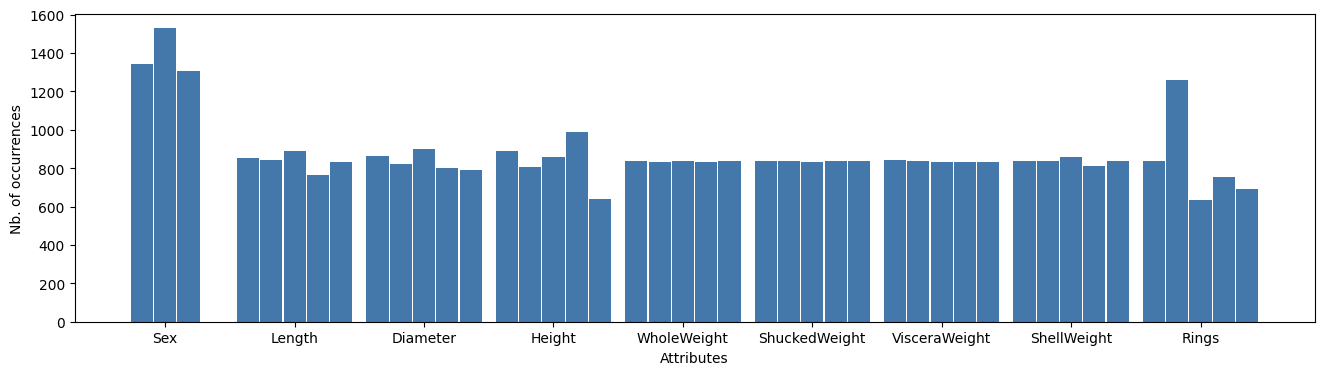

In [14]:
plt.figure(figsize=(16,4))
h = numpy.sum(bin_mat, axis=0)
bw = 0.9/numpy.max(item_nbs)
bf = 0.95
xbs = []
for ni, nb in enumerate(item_nbs):
    xbs.extend([ni+(n-0.5*(nb-1+bf))*bw for n in range(nb)])
plt.bar(xbs, h, width=bf*bw, align='edge', color=(68/255., 119/255., 170/255.))
plt.xticks(range(len(cnames)), cnames)
plt.xlabel("Attributes")
plt.ylabel("Nb. of occurrences")
plt.show()

Except for the number of rings, where the item corresponding to 7 or 8 rings is more frequent than the other items, the thresholds used to discretize the numerical attributes result in bins of approximately equal heights. As a consequence, the resulting items appear with roughly the same frequency, of about 4177/5 or 20%.

The frequencies of the three items generated from the *Sex* attribute correspond to the distribution, in the abalone population covered by the dataset, of infants, males and females, respectively. 

## Mining itemsets

Now, we are ready to run the frequent itemset mining algorithm on the transactional dataset.

First, we try with a relatively high support threshold, of 15% (0.15 x 4177 ~ 626).

In [15]:
nb_tot = len(tracts)
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=15)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 190 itemsets in 0:00:00.021004


Several dozens of frequent itemsets were mined in fractions of a second.

Let's have a look at the top ten most frequent.

In [16]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

Sex_M (1,) 1528 0.366
Sex_I (0,) 1342 0.321
Sex_F (2,) 1307 0.313
Rings_(7.0,9.0] (39,) 1257 0.301
Height_(0.15,0.175] (16,) 986 0.236
Diameter_(0.395,0.45] (10,) 902 0.216
Height_..0.105] (13,) 888 0.213
Length_(0.51,0.575] (5,) 887 0.212
Diameter_..0.325] (8,) 863 0.207
Height_(0.13,0.15] (15,) 858 0.205


Expectedly, the most frequent itemsets are singletons, i.e. they correspond to occurrences of individual physical properties. This is of limited interest, we could already see these frequencies in the histogram.

Next, we lower slightly the support threshold, to 500 occurrences.

In [17]:
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=-500)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 529 itemsets in 0:00:00.020593


More than twice as many itemsets are returned...

Lowering the support threshold again, now to 250 occurrences.

In [18]:
tic = datetime.datetime.now()
FI = fim(tracts, target='s', supp=-250)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 1187 itemsets in 0:00:00.027987


More than a thousand itemsets are returned...

Now keeping the support threshold constant, but mining the closed frequent itemsets (target='c').

In [19]:
tic = datetime.datetime.now()
FI = fim(tracts, target='c', supp=-250)  # target='c' means we're targeting the closed frequent itemsets
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 1176 itemsets in 0:00:00.028993


And again, with the same support threshold, but this time mining the maximal frequent itemsets (target='m').

In [20]:
tic = datetime.datetime.now()
FI = fim(tracts, target='m', supp=-250)  # target='m' means we're targeting the maximal frequent itemsets
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 136 itemsets in 0:00:00.042017


Finally, we mine closed frequent itemsets with a support threshold of 10%, keeping only itemsets of size three or more (zmin=3).

In [21]:
tic = datetime.datetime.now()
FI = fim(tracts, target='c', supp=10, zmin=3)
elps = datetime.datetime.now() - tic
print("Found %d itemsets in %s" % (len(FI), elps))

Found 561 itemsets in 0:00:00.022983


Among these hundreds of itemsets, we look at the top ten, where we can find the most common co-occurrences of physical attributes.

In [22]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))  #? labels, itemset, abs supp, rel. supp

WholeWeight_..0.366] Length_..0.425] Diameter_..0.325] (18, 3, 8) 783 0.187
ShellWeight_..0.109] Length_..0.425] Diameter_..0.325] (33, 3, 8) 774 0.185
ShellWeight_..0.109] WholeWeight_..0.366] Diameter_..0.325] (33, 18, 8) 767 0.184
VisceraWeight_..0.0765] Length_..0.425] Diameter_..0.325] (28, 3, 8) 765 0.183
ShellWeight_..0.109] WholeWeight_..0.366] Length_..0.425] (33, 18, 3) 764 0.183
WholeWeight_..0.366] VisceraWeight_..0.0765] Length_..0.425] (18, 28, 3) 761 0.182
WholeWeight_..0.366] VisceraWeight_..0.0765] Diameter_..0.325] (18, 28, 8) 761 0.182
ShellWeight_..0.109] WholeWeight_..0.366] Length_..0.425] Diameter_..0.325] (33, 18, 3, 8) 757 0.181
WholeWeight_..0.366] VisceraWeight_..0.0765] Length_..0.425] Diameter_..0.325] (18, 28, 3, 8) 756 0.181
WholeWeight_..0.366] ShuckedWeight_..0.157] Length_..0.425] (18, 23, 3) 754 0.181


We might be interested to carry this analysis further. For instance, we might look for association rules that relate dimensions of the abalone, its age (nb. of rings) and its sex...

## Observations

Top occurences of each attribute:
- Sex: Male
- Length: 0.51-0.575
- Diameter: 0.395-0.45
- Height: 0.15-0.175
- WholeWeight: equivalent
- ShuckedWeight: equivalent
- VisceraWeight: min - 0.0765
- ShellWeight: 0.1895-0.27
- Rings: 9-10

Most common co-occurences of physical attributes (supp. thresh. of 10%, itemset size > 3):
1. WholeWeight, Length, Diameter
2. ShellWeight, Length, Diameter
3. ShellWeight, WholeWeight, Diameter
4. VisceraWeight, Length, Diameter
5. ShellWeight, WholeWeight, Length

Looking at the top 5, there seems to be an association between weight and size of the anemole. But what about the other attributes, such as sex and rings? Does the number of rings correlate to the weight and size of the anemole, or is it the sex?

### Sex and Rings

Sex is identified by labels:
0 - Infant
1 - Male
2 - Female

And rings are identfied by labels from 38 to 42 (increases number of rings as the label number increases)

In [23]:
print(f"- Sex: {item_lbls[0:3]} \n- Rings: {item_lbls[38:43]}")

- Sex: ['Sex_I', 'Sex_M', 'Sex_F'] 
- Rings: ['Rings_..7.0]', 'Rings_(7.0,9.0]', 'Rings_(9.0,10.0]', 'Rings_(10.0,12.0]', 'Rings_(12.0..']


Let's sort the top 10 itemsets to include either of those.

In [24]:
# Generate lists with labels of sex and ring attributes
sex_labels = list(range(0, 2))
ring_labels = list(range(38, 43))
both_labels = sex_labels + ring_labels
print_limit = 10
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in both_labels for attr in fi[0]):  # Only look at itemset including sex and rings
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Length_..0.425] Sex_I Diameter_..0.325] (3, 0, 8) 608 0.146
ShellWeight_..0.109] Sex_I Diameter_..0.325] (33, 0, 8) 605 0.145
ShellWeight_..0.109] Sex_I WholeWeight_..0.366] (33, 0, 18) 601 0.144
WholeWeight_..0.366] Sex_I Diameter_..0.325] (18, 0, 8) 601 0.144
WholeWeight_..0.366] Sex_I Length_..0.425] (18, 0, 3) 599 0.143
ShellWeight_..0.109] Sex_I Length_..0.425] (33, 0, 3) 598 0.143
WholeWeight_..0.366] Sex_I VisceraWeight_..0.0765] (18, 0, 28) 596 0.143
VisceraWeight_..0.0765] Sex_I Diameter_..0.325] (28, 0, 8) 592 0.142
WholeWeight_..0.366] Sex_I Length_..0.425] Diameter_..0.325] (18, 0, 3, 8) 589 0.141
ShellWeight_..0.109] Sex_I Length_..0.425] Diameter_..0.325] (33, 0, 3, 8) 588 0.141


With both labels, we see that sex infant is the most common. Restricting the results to those that contain rings gives the following:

In [25]:
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in ring_labels for attr in fi[0]):  # Only look at itemsets including rings
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Rings_..7.0] Length_..0.425] Diameter_..0.325] (38, 3, 8) 586 0.140
ShellWeight_..0.109] Rings_..7.0] Diameter_..0.325] (33, 38, 8) 581 0.139
ShellWeight_..0.109] Rings_..7.0] Length_..0.425] (33, 38, 3) 577 0.138
ShellWeight_..0.109] Rings_..7.0] WholeWeight_..0.366] (33, 38, 18) 576 0.138
WholeWeight_..0.366] Rings_..7.0] Length_..0.425] (18, 38, 3) 575 0.138
WholeWeight_..0.366] Rings_..7.0] Diameter_..0.325] (18, 38, 8) 575 0.138
ShellWeight_..0.109] Rings_..7.0] Height_..0.105] (33, 38, 13) 569 0.136
ShellWeight_..0.109] Rings_..7.0] Length_..0.425] Diameter_..0.325] (33, 38, 3, 8) 569 0.136
ShellWeight_..0.109] Rings_..7.0] WholeWeight_..0.366] Diameter_..0.325] (33, 38, 18, 8) 568 0.136
Rings_..7.0] VisceraWeight_..0.0765] Length_..0.425] (38, 28, 3) 568 0.136


From the resulting itemsets, it can be seen that only abalones of sex infant and with less than 7 rings appear. This means that younger abalones are frequently more similar in physical attributes than older ones. Or, in other words, as abalones grow older, they gain differing characteristics, and thus the itemsets related to those are not so frequent.

What about adult abalones?

In [26]:
# Lower the support threshold
FI = fim(tracts, target='c', supp=-100, zmin=3)
print("Found %d itemsets in %s" % (len(FI), elps))

sex_labels = list(range(1, 2))
ring_labels = list(range(38, 43))
i = 0

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in sex_labels for attr in fi[0]) and any(attr in ring_labels for attr in fi[0]):
        if i < print_limit:
            print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 2889 itemsets in 0:00:00.022983
ShellWeight_(0.1895,0.27] Sex_M Rings_(7.0,9.0] (35, 1, 39) 159 0.038
Rings_(10.0,12.0] Length_(0.625.. Sex_M (41, 7, 1) 155 0.037
Rings_(10.0,12.0] ShuckedWeight_(0.542.. Sex_M (41, 27, 1) 152 0.036
Rings_(10.0,12.0] WholeWeight_(1.2385.. Sex_M (41, 22, 1) 149 0.036
Rings_(12.0.. ShellWeight_(0.351.. Sex_M (42, 37, 1) 148 0.035
Rings_(10.0,12.0] Diameter_(0.495.. Sex_M (41, 12, 1) 145 0.035
Rings_(10.0,12.0] ShellWeight_(0.351.. Sex_M (41, 37, 1) 143 0.034
Rings_(10.0,12.0] WholeWeight_(1.2385.. Sex_M ShuckedWeight_(0.542.. (41, 22, 1, 27) 142 0.034
Rings_(10.0,12.0] VisceraWeight_(0.273.. Sex_M (41, 32, 1) 142 0.034
ShuckedWeight_(0.4,0.542] Rings_(7.0,9.0] Sex_M (26, 39, 1) 141 0.034


With a low support threshold of 100 and minimum itemset size of 3, we're able to find 2889 itemsets that fit the criteria of either being male or female in sex, and containing the number of rings attributes.

The most common case is that of a male abanole with 7 to 9 rings and shell weight between 0.1895 and 0.27. As this abanole is younger than the other male abanoles in the ranking, there's an indication that the assumption of younger abanoles resembling eachother is correct. For the other cases, the most common number of rings in male abanoles is a value between 10 and 12.